In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata

from dredFISH.Design import PNMF
from dredFISH.Utils import basicu
from dredFISH.Utils.__init__plots import * 

import importlib
importlib.reload(PNMF)


<module 'dredFISH.Design.PNMF' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Design/PNMF.py'>

In [4]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

# data
scrna_genes_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_genes_matrix.h5ad'

In [5]:
%%time
# allen scrna matrix
adata = anndata.read_h5ad(scrna_genes_path) # library size normed (no log)
adata

CPU times: user 709 ms, sys: 1.89 s, total: 2.59 s
Wall time: 9.45 s


AnnData object with n_obs × n_vars = 73347 × 5576
    obs: 'donor_sex_id', 'donor_sex_label', 'donor_sex_color', 'region_id', 'region_label', 'region_color', 'platform_label', 'cluster_order', 'cluster_label', 'cluster_color', 'subclass_order', 'subclass_label', 'subclass_color', 'neighborhood_id', 'neighborhood_label', 'neighborhood_color', 'class_order', 'class_label', 'class_color', 'exp_component_name', 'external_donor_name_label', 'full_genotype_label', 'facs_population_plan_label', 'injection_roi_label', 'injection_materials_label', 'injection_method_label', 'injection_type_label', 'full_genotype_id', 'full_genotype_color', 'external_donor_name_id', 'external_donor_name_color', 'facs_population_plan_id', 'facs_population_plan_color', 'injection_materials_id', 'injection_materials_color', 'injection_method_id', 'injection_method_color', 'injection_roi_id', 'injection_roi_color', 'injection_type_id', 'injection_type_color', 'cell_type_accession_label', 'cell_type_alias_label', 'cel

In [6]:
%%time
X = np.array(adata.X.todense()).copy() # already library size normalized
logX = np.log10(X+1)

CPU times: user 7.85 s, sys: 2.51 s, total: 10.4 s
Wall time: 10.4 s


In [7]:
%%time

# run PNMF logtrans -- recommended by them
w_pca, rec_pca = PNMF.get_PNMF(logX.T, init='pca', k=24, verbose=True, report_stride=2)
# w_nrm, rec_nrm = PNMF.get_PNMF(logX.T, init='normal', k=24, verbose=True, report_stride=2)
# w_uni, rec_uni = PNMF.get_PNMF(logX.T, init='uniform', k=24, verbose=True, report_stride=2)

0 0.2757459022038944
2 0.011595109238911938
4 0.0007217032001438951
6 4.7675670830813486e-05
8 7.550207617546304e-06
CPU times: user 5min 46s, sys: 7.87 s, total: 5min 54s
Wall time: 14.5 s


In [58]:
def calc_err(x, w, rho=1):
    """
    X: (p, n)
    w: (p, k)
    """
    return np.linalg.norm(x-rho*w.dot(w.T.dot(x)), ord='fro')**2

def calc_ss(x):
    """
    X: (p, n)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return (np.linalg.norm(xcentered, ord='fro')**2)

def calc_r2(x, w):
    """
    X: (p, n)
    w: (p, k)
    """
    xmean = np.mean(x, axis=1)
    xcentered = x-xmean.reshape(-1,1)
    return 1 - calc_err(x, w)/calc_ss(x)

In [59]:
ss = calc_ss(logX.T)

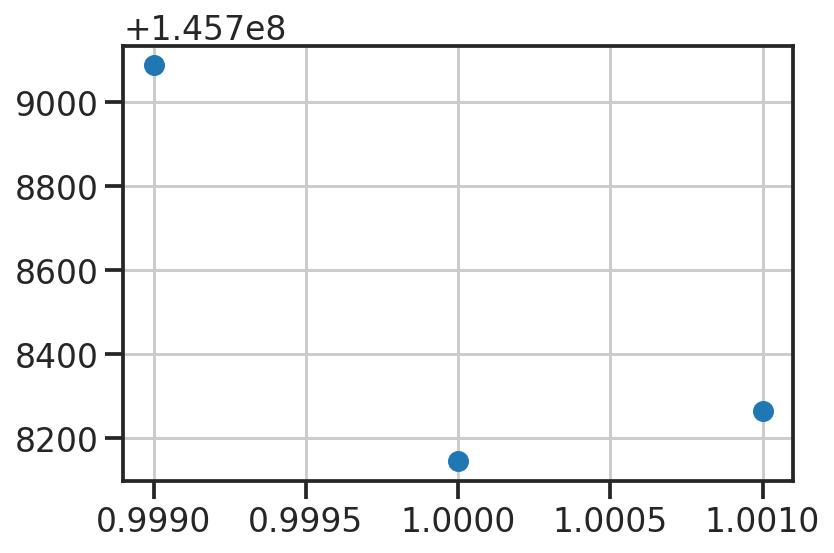

In [45]:
# check W has the right scale
errs = []
rhos = [0.999, 1, 1.001]
for rho in rhos:
    err = calc_err(logX.T, w_pca, rho=rho)
    errs.append(err)

fig, ax = plt.subplots()
ax.scatter(rhos, errs)
plt.show()

In [55]:
errs = []
nbasis = [3,6,12,24,48,96]
for k in nbasis:
    print(k, end=',')
    # w, rec = PNMF.get_PNMF(logX.T, init='pca', k=k, verbose=False, report_stride=2)
    w, rec = PNMF.get_PNMF(logX.T, init='normal', k=k, verbose=False, report_stride=2)
    err = calc_err(logX.T, w)
    print(w.shape, err)
    errs.append(err)
errs

3,(5576, 3) 146111310.04381955
6,(5576, 6) 146106718.37441224
12,(5576, 12) 146105817.64347807
24,(5576, 24) 146104612.28353897
48,(5576, 48) 146103881.24753106
96,(5576, 96) 146102061.00828215


[146111310.04381955,
 146106718.37441224,
 146105817.64347807,
 146104612.28353897,
 146103881.24753106,
 146102061.00828215]

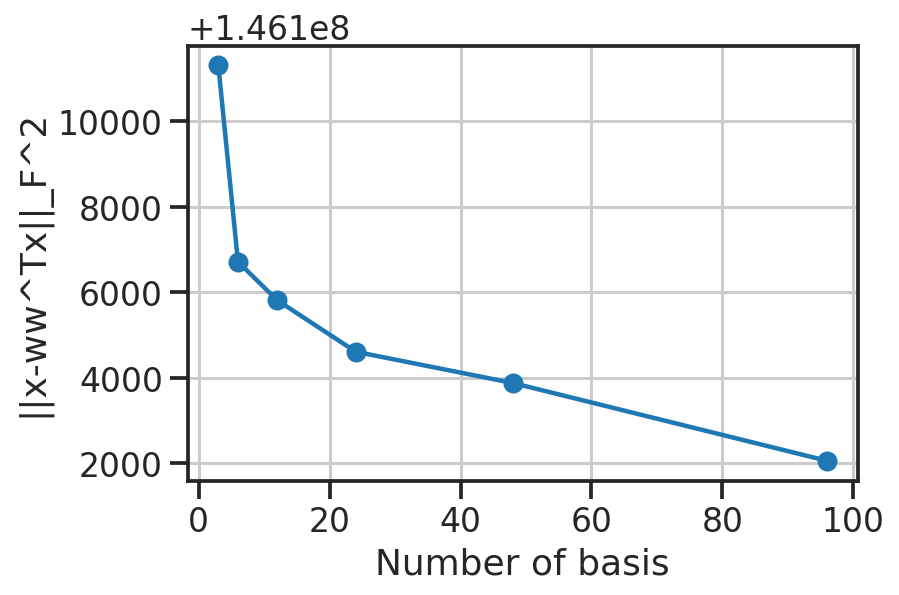

In [56]:
fig, ax = plt.subplots()
ax.plot(nbasis, errs, '-o')
ax.set_ylabel('||x-ww^Tx||_F^2')
ax.set_xlabel('Number of basis')
plt.show()

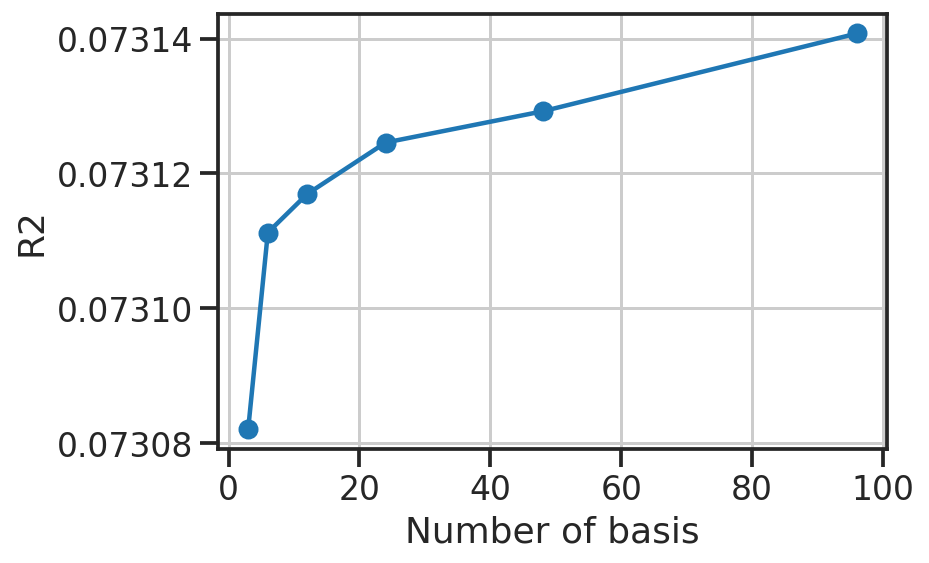

In [63]:
fig, ax = plt.subplots()
ax.plot(nbasis, 1-np.array(errs)/ss, '-o')
ax.set_ylabel('R2')
ax.set_xlabel('Number of basis')
plt.show()

In [12]:
def plot(w, ax, vmax=None, reorder=True):
    if reorder:
        wnew, rows, cols = basicu.diag_matrix_rows(w)
    else:
        wnew = w
        
    sns.heatmap(
                # np.log10(wnew+1), 
                wnew,
                ax=ax, 
                cmap='rocket_r', 
                cbar_kws=dict(shrink=0.5),
                vmax=vmax,
               )

In [ ]:
# vmax = 0.1
# # vmax = 0.03
# fig, axs = plt.subplots(1, 3, figsize=(7*3,8))
# ax = axs[0]
# plot(w_pca, ax, vmax=vmax)
# ax.set_title('|PCA|')
# ax = axs[1]
# plot(w_nrm, ax, vmax=vmax)
# ax.set_title('random |~Normal|')
# ax = axs[2]
# plot(w_uni, ax, vmax=vmax)
# ax.set_title('random ~Uniform')
# plt.show()